In [44]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from model import TwoResAutoEncoder
from data import FaceDataset
from train import create_fg_masks
import matplotlib.pyplot as plt
from feather import stitch
import os

In [45]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"

model = torch.load('./boiNet250,750.pt')
model.to(device)

TwoResAutoEncoder(
  (fg_ae): FGAutoencoder(
    (encoder): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU()
      (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (9): Flatten(start_dim=1, end_dim=-1)
      (10): Linear(in_features=7040, out_features=250, bias=True)
      (11): ReLU()
    )
    (decoder): Sequential(
      (0): Linear(in_features=250, out_features=7040, bias=True)
      (1): ReLU()
      (2): Unflatten(dim=1, unflattened_size=(64, 11, 10))
      (3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 

In [46]:
# dataset = FaceDataset('test_set_bb.csv', '../boxes/celeba_imgs', return_im_num=True)
dataset = FaceDataset('../boxes/norm_bounding_boxes.csv', '../boxes/celeba_imgs', return_im_num=True)

# dataset = Subset(dataset, range(2200, 2400))

output_folder = 'compressed-250,750'
os.makedirs(output_folder, exist_ok=True)

In [47]:
loader = DataLoader(dataset, batch_size=32)

for img_num, images, faces, bboxs in loader:

    print(images.shape)
    images, faces = images.to(device), faces.to(device)
    filenames = []
    
    fg_masks = create_fg_masks(bboxs).to(device)
    fg_output, bg_output = model(images * (~fg_masks), faces)
    
    rec = stitch(fg_output, bg_output, bboxs.to(device), feather_size=20, device=device)
    # break
    # # Save images
    for i in range(img_num.shape[0]):
        torchvision.utils.save_image(rec[i], os.path.join(output_folder, f'{img_num[i]}.png'))
    break

torch.Size([32, 3, 218, 178])


In [114]:
import numpy as np
import matplotlib.pyplot as plt

def plot_tensor(tensor, title="Tensor Image Batch"):
    """
    Plots images from a 4D tensor (batch, C, W, H) with 3 color channels, and adds a title to the plot.
    
    Args:
    tensor (numpy.ndarray): The 4D tensor to plot, with shape (batch, C, W, H).
    title (str): The title of the plot.
    """
    if tensor.shape[1] != 3:
        raise ValueError("Tensor must have 3 channels")

    batch_size = tensor.shape[0]
    rows = (batch_size + 5) // 6  # Calculate the number of rows needed

    fig, axes = plt.subplots(rows, 6, figsize=(18, 4 * rows))  # Adjust the figsize here
    fig.tight_layout(pad=3.0)  # Increase padding to accommodate the title

    fig.suptitle(title, fontsize=16)  # Set the title for the whole figure

    # Flattening the axes array for easy iteration
    axes = axes.ravel()

    for i in range(batch_size):
        # Transpose tensor to shape (W, H, C) for plotting
        img = tensor[i].permute(1, 2, 0)
        axes[i].imshow(img)
        axes[i].axis('off')  # Turn off axis
    
    # Turn off axes for any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.show()


In [99]:
# test_imgs = [1, 5, 9, 13]

d = [dataset[i + 501] for i in range(6)] 

def plot_model(model, data, title):
    l = DataLoader(data, batch_size=10)


    for img_num, images, faces, bboxs in l:
        images, faces = images.to(device), faces.to(device)

        fg_masks = create_fg_masks(bboxs).to(device)
        fg_output, bg_output = model(images * (~fg_masks), faces)
        
        rec = stitch(fg_output, bg_output, bboxs.to(device), feather_size=20, device=device)

        plot_tensor(rec.detach(), title)

        # break
        return rec.detach()


In [100]:
model = torch.load('./boiNet500,500.pt')
model.to(device)
plot_model(model, d)

TypeError: plot_model() missing 1 required positional argument: 'title'

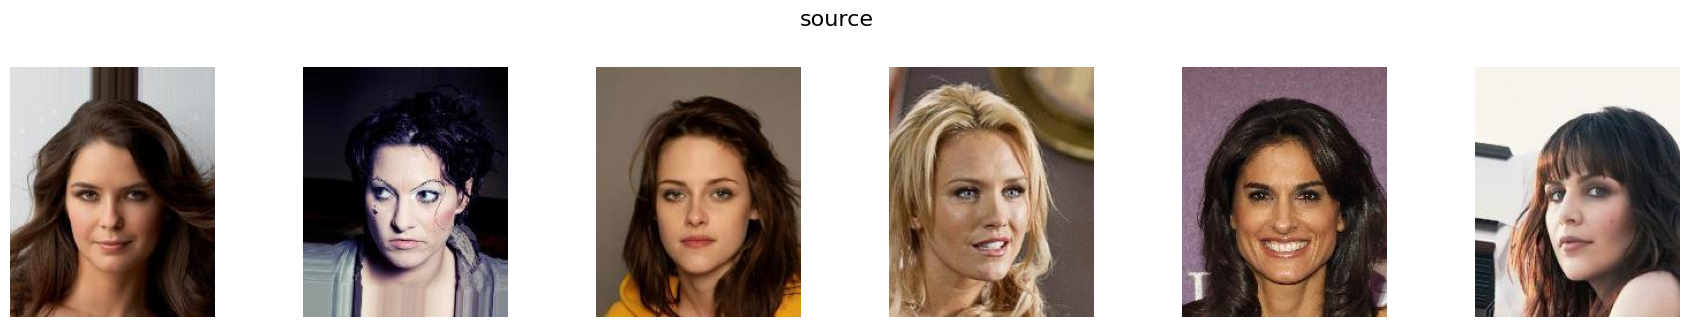

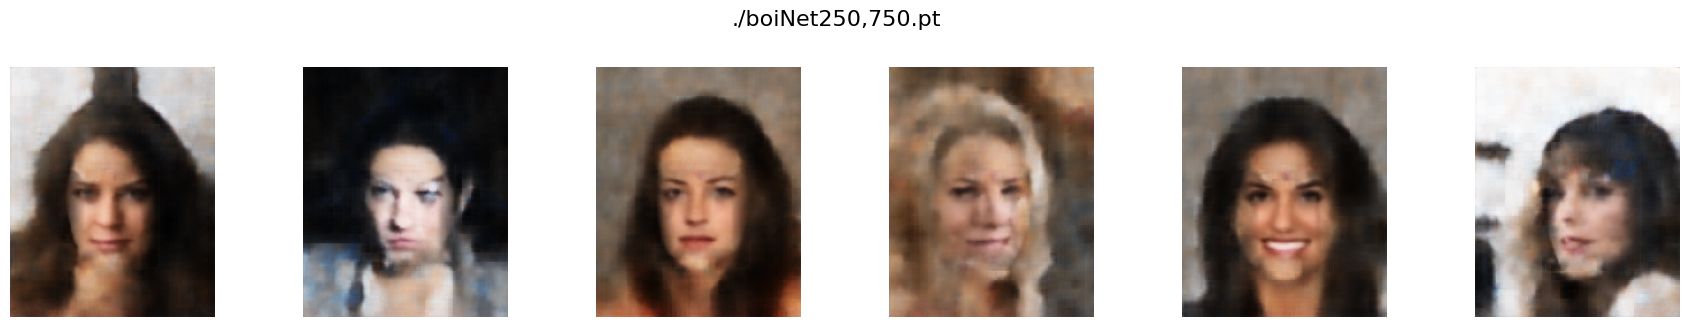

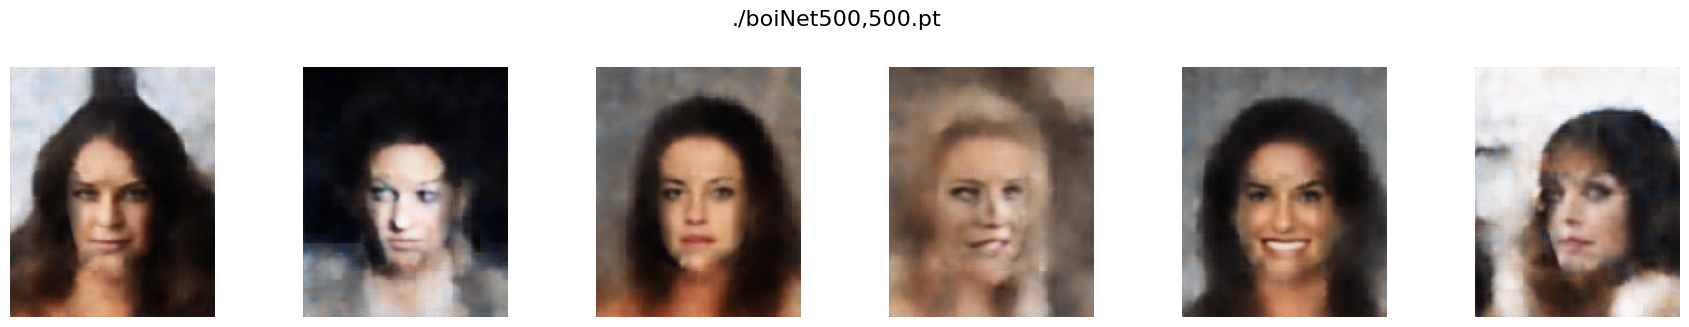

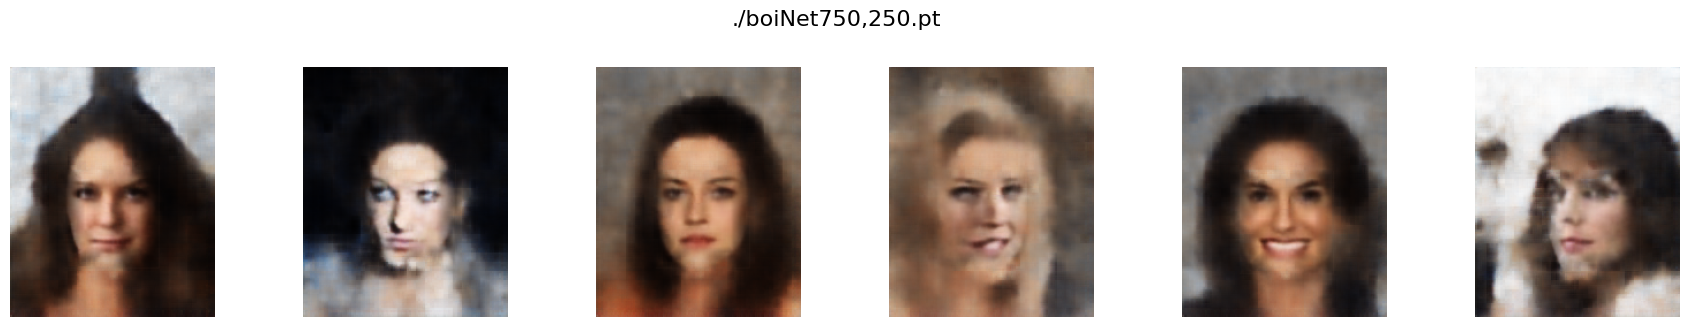

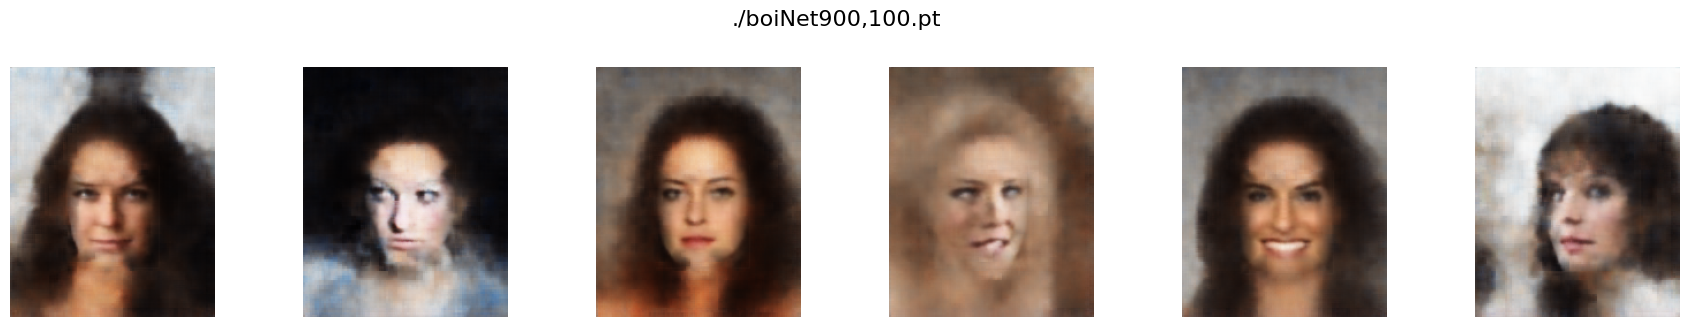

In [116]:
models = ['./boiNet250,750.pt',
          './boiNet500,500.pt',
            './boiNet750,250.pt',
            './boiNet900,100.pt',
          ]

images = torch.stack([i[1] for i in d])
# images
plot_tensor(images, "source")

for m in models:
    model = torch.load(m)
    model.to(device)
    plot_model(model, d, m)
    # images.shape
# plot_tensor(images)
